In [2]:
import pandas as pd
import os
import numpy as np

In [18]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import sys
sys.path.append("/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
sys.path.insert(1, '/cellar/users/mpagadal/Data/scripts')

In [6]:
import myvariant
mv = myvariant.MyVariantInfo()

In [47]:
def process_data(file,analysis_type):
    if analysis_type=="linear":
        df=pd.read_csv(file,delimiter="\t",header=None)
        df.columns=["#CHROM","POS","ID","REF","ALT","A1","TEST","OBS_CT","BETA","SE","T_STAT","P","ERRCODE"]
        df["P"]=df["P"].astype(float)
        df['minuslog10pvalue'] = -np.log10(df["P"])
        df["#CHROM"]=df["#CHROM"].replace("X",23)
        df["#CHROM"]=pd.to_numeric(df["#CHROM"])
        df["#CHROM"] = df["#CHROM"].astype('category')
        df = df.sort_values('#CHROM')
        df['ind'] = range(len(df))
        return df
    if analysis_type=="logistic":
        df=pd.read_csv(file,delimiter="\t")
        df['minuslog10pvalue'] = -np.log10(df["P"])
        df["#CHROM"]=df["#CHROM"].replace("X",23)
        df["#CHROM"]=pd.to_numeric(df["#CHROM"])
        df["#CHROM"] = df["#CHROM"].astype('category')
        df = df.sort_values('#CHROM')
        df['ind'] = range(len(df))
        return df

In [7]:
def plot_manhattan_annotate(processed_data,title,color_list,files_known_snps,colors_known_snps):
    '''
    Input: dataframe with P values
    Output: Manhattan plot
    '''
    df=processed_data
    df_grouped = df.groupby(('#CHROM'))
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    colors = color_list
    x_labels = []
    x_labels_pos = []
    for num, (name, group) in enumerate(df_grouped):
        group.plot(kind='scatter', x='ind', y='minuslog10pvalue',color=colors[num % len(colors)],ax=ax,rasterized=True)
        x_labels.append(name)
        x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))

    
    for num,file in enumerate(files_known_snps):
        snps=pd.read_csv(file,header=None)
        snps=snps[0].tolist()
        df_label=df[df["ID"].isin(snps)]
        print(df_label.shape)
        for i,row in df_label.iterrows():
            ax.scatter(row["ind"],row["minuslog10pvalue"],color=colors_known_snps[num],rasterized=True)
            
    ax.axhline(y=7.30, color='r', linestyle='-')
    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels)
    ax.set_xlim([0, len(df)])
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('-log10 P value')
    ax.set_title(title+' GWAS Manhattan plot')
    fig.savefig(title+'.manhattan.labeled.pdf')
    #plt.close()

## Get conditional snps

In [8]:
def extract(directory):
    df_hla_cond=pd.DataFrame()
    files=[x for x in os.listdir(directory) if "extract" in x]
    print(len(files))
    for x in files:
        df=pd.read_csv(directory+x,header=None)
        df["pheno"]=x.split(".extract")[0]
        df["iteration"]=df.index
        df_hla_cond=df_hla_cond.append(df)
    df_hla_cond.columns=["snp","file","iteration"]
    return(df_hla_cond)
    

In [9]:
def extract_beta(hla_df,betas):
    beta_values=[]
    p_values=[]

    for i,row in hla_df.iterrows():
        file=row["file"]+"."+str(row["iteration"])+".GWAS.ADD.filtered"
        try:
            df=pd.read_csv(betas+"/"+file,header=None,sep="\t")
            beta=df[(df[2]==row["snp"])&(df[6]=="ADD")][8].values[0]
            beta_values.append(beta)
            p=df[(df[2]==row["snp"])&(df[6]=="ADD")][11].values[0]
            p_values.append(p)
        except:
            beta=np.nan
            beta_values.append(beta)
            p=np.nan
            p_values.append(p)
            
    hla_df["beta"]=beta_values
    hla_df["p"]=p_values
    return(hla_df)
    

## Get HLA-conditional variants from all 3 pipelines

In [11]:
tpm=extract("/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/associations/raw/conditional/tpm/")
firebrowse=extract("/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/associations/raw/conditional/firebrowse/")
pancan=extract("/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/associations/raw/conditional/pancanatlas/")

14
17
17


In [13]:
tpm=extract_beta(tpm,"/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/associations/filtered/tpm")
firebrowse=extract_beta(firebrowse,"/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/associations/filtered/firebrowse")
pancan=extract_beta(pancan,"/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/associations/filtered/pancanatlas")

# Get variants that are called by at least 2 RNA-sequencing pipelines

In [25]:
hla=tpm[["snp","file"]].append(firebrowse[["snp","file"]])
hla=hla.append(pancan[["snp","file"]])

In [26]:
#get conditional snps identified in at least 2 RNA pipelines
hla_counts=hla.groupby(["snp","file"]).size().reset_index()
hla_consensus=hla_counts[hla_counts[0]>1]["snp"].tolist()

In [27]:
hla_sig=hla[hla["snp"].isin(hla_consensus)]

## Get only chromosome 6

In [29]:
hla_sig["chr"]=hla_sig["snp"].str.split(":").str[0]
hla_sig6=hla_sig[hla_sig["chr"]=="6"]

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
print(hla_sig6.shape)
hla_sig6.head()

(82, 3)


,snp,file,chr
1,6:29697517:G:A,HLA.F,6
8,6:31364076:C:T,HLA.B,6
9,6:31322980:C:T,HLA.C,6
2,6:31458936:A:T,MICB,6
5,6:32403119:G:A,HLA.DRB5,6


## Get p and beta values of consensus variants

In [32]:
hla_merge=pd.merge(hla_sig6,tpm,on=["snp","file"],how="left",suffixes=('', '_tpm'))
hla_merge=pd.merge(hla_merge,firebrowse,on=["snp","file"],how="left",suffixes=('', '_firebrowse'))
hla_merge=pd.merge(hla_merge,pancan,on=["snp","file"],how="left",suffixes=('', '_pancan'))

In [34]:
hla_merge["beta mean"]=hla_merge[["beta", "beta_firebrowse","beta_pancan"]].mean(axis=1)

In [36]:
hla_merge["consensus p-value"]=hla_merge[["p", "p_firebrowse","p_pancan"]].min(axis=1)

In [37]:
hla_merge.head()

,snp,file,chr,iteration,beta,p,iteration_firebrowse,beta_firebrowse,p_firebrowse,iteration_pancan,beta_pancan,p_pancan,beta mean,consensus p-value
0,6:29697517:G:A,HLA.F,6,1.0,-0.469363,2.45861e-115,0.0,0.166567,7.788940e-20,0.0,0.168388,5.951230e-21,-0.044803,2.458610e-115
1,6:31364076:C:T,HLA.B,6,8.0,0.094710,4.98091e-18,NaN,NaN,NaN,NaN,NaN,NaN,0.094710,4.980910e-18
2,6:31322980:C:T,HLA.C,6,9.0,0.057450,8.95292e-08,NaN,NaN,NaN,NaN,NaN,NaN,0.057450,8.952920e-08
3,6:31458936:A:T,MICB,6,2.0,-0.223481,1.09084e-08,1.0,-0.389792,2.095370e-17,1.0,-0.387488,4.846910e-18,-0.333587,4.846910e-18
4,6:32403119:G:A,HLA.DRB5,6,5.0,-0.385607,1.40826e-46,NaN,NaN,NaN,4.0,-0.254001,3.540090e-11,-0.319804,1.408260e-46


## Plot manhattan

In [48]:
df=process_data("/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/associations/raw/conditional/tpm/TAP2.4.GWAS.ADD","linear")

In [49]:
df=df[df["#CHROM"]==6]
df=df[df["POS"]>32700000]
df=df[df["POS"]<32800000]

In [50]:
snps=["6:32789480:A:G","6:32796793:G:A"]

In [51]:
df[df["ID"].isin(snps)]

,#CHROM,POS,ID,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,ERRCODE,minuslog10pvalue,ind
2949444,6,32789480,6:32789480:A:G,A,G,G,ADD,7113,0.597560,0.063428,9.42103,5.918920e-21,.,20.227758,3127959
2949522,6,32796793,6:32796793:G:A,G,A,A,ADD,7113,-0.142052,0.022416,-6.33691,2.487700e-10,.,9.604202,3128129


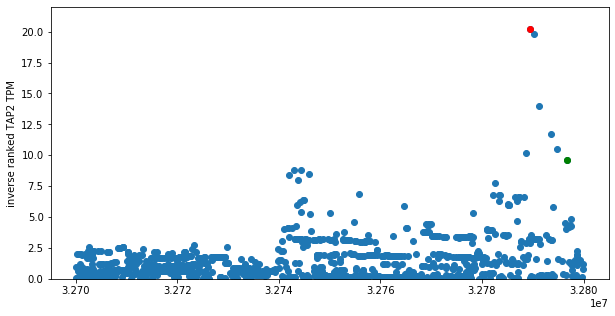

In [53]:
f=plt.figure(figsize=(10,5))
plt.scatter(df["POS"],df["minuslog10pvalue"])
plt.scatter(32789480,20.227758,color="red",rasterized=True)
plt.scatter(32796793,9.604202,color="green",rasterized=True)
plt.ylabel("inverse ranked TAP2 TPM")
plt.ylim([0, 22])
plt.savefig("../plots/tap2.iteration4.pdf")

In [55]:
df=process_data("/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/associations/raw/conditional/tpm/TAP2.5.GWAS.ADD","linear")

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [56]:
df=df[df["#CHROM"]==6]
df=df[df["POS"]>32700000]
df=df[df["POS"]<32800000]

In [57]:
df[df["ID"].isin(snps)]

,#CHROM,POS,ID,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,ERRCODE,minuslog10pvalue,ind
2949444,6,32789480,6:32789480:A:G,A,G,G,ADD,7113,NaN,NaN,NaN,NaN,CORR_TOO_HIGH,NaN,3127959
2949522,6,32796793,6:32796793:G:A,G,A,A,ADD,7113,-0.147194,0.02228,-6.60649,4.220380e-11,.,10.374648,3128129


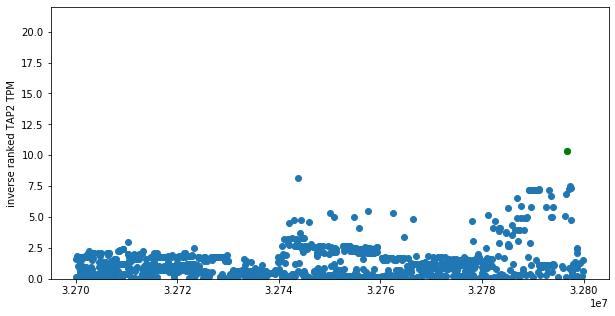

In [58]:
f=plt.figure(figsize=(10,5))
plt.scatter(df["POS"],df["minuslog10pvalue"])
plt.scatter(32796793,10.374648,color="green",rasterized=True)
plt.ylabel("inverse ranked TAP2 TPM")
plt.ylim([0, 22])
plt.savefig("../plots/tap2.iteration5.pdf")

## make conditional plot

In [59]:
hla_merge["bp1"]=hla_merge["snp"].str.split(":").str[1]
hla_merge["bp1"]=pd.to_numeric(hla_merge["bp1"])

In [60]:
hla_merge["-log10p"]=-np.log10(hla_merge["consensus p-value"])

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [61]:
hla_merge["-log10p"]=hla_merge["-log10p"].replace(np.inf, np.nan)
hla_merge["-log10p"]=hla_merge["-log10p"].fillna(hla_merge["-log10p"].max())

## Get allele-specific HLA snps

In [62]:
def get_clumps(directory,snp_type):
    '''
    Input: directory with all plink .clumped files to be aggregated
    Output: dataframe with INDEX SNP, p-value, association paramter
    '''
    #get clumped files
    files=os.listdir(directory)
    file_lst=[x for x in files if ".clumped" in x]
    
    if snp_type == "index":
    
        #iterate through all clumped files and extract index snps
        snps=[]
        assoc=[]
        p=[]

        for x in file_lst:
            file=pd.read_csv(directory+"/"+x, delim_whitespace=True)
            for i,row in file.iterrows():
                snps.append(row["SNP"])
                p.append(row["P"])
                assoc.append(x.split(".clump.clumped")[0])
    
        df=pd.DataFrame({"snps":snps,"file":assoc,"p-value":p})
        return(df)
    
    if snp_type == "all":
        snps=[]
        indexsnp=[]
        assoc=[]
        p=[]

        for x in file_lst:
            file=pd.read_csv(directory+"/"+x, delim_whitespace=True)
            for i,row in file.iterrows():
                for y in row["SP2"].split("(1),"):
                    snps.append(y)
                    indexsnp.append(row["SNP"])
                    p.append(row["P"])
                    assoc.append(x.split(".clump.clumped")[0])
                
        df=pd.DataFrame({"indexsnps":indexsnp,"snps":snps,"file":assoc,"p-value":p})
        df=df[~(df["snps"]=="")]
        df=df[~(df["snps"]=="NONE")]
        df["snps"]=df["snps"].str.split("(").str[0]
        return(df)

In [63]:
def compiled(directory):
    files=os.listdir(directory)
    
    compiled=pd.DataFrame()
    
    for x in files:
        try:
            df=pd.read_csv(directory+"/"+x,delimiter="\t",header=None)
            df_filt=df[df[6]=="ADD"]
            df_filt["file"]=x.split(".sig.snps")[0]
            compiled=compiled.append(df_filt)
        except:
            print(x)
    
    return(compiled)

In [64]:
def map_rsid(x):
    '''
    Input: SNP format (chr:bp:minor:major)
    Output: tuple (variant,rsid)
    '''
    try:
        var="chr"+x.split(":")[0]+":g."+x.split(":")[1]+x.split(":")[2]+">"+x.split(":")[3]
        rs=mv.getvariants(var,fields='dbsnp.rsid')[0]["dbsnp"]["rsid"]
    except:
        try:
            var="chr"+x.split(":")[0]+":g."+x.split(":")[1]+x.split(":")[3]+">"+x.split(":")[2]
            rs=mv.getvariants(var,fields='dbsnp.rsid')[0]["dbsnp"]["rsid"]
        except:
            var="chr"+x.split(":")[0]+":g."+x.split(":")[1]+x.split(":")[3]+">"+x.split(":")[2]
            rs=""
    
    return (var,rs)

In [66]:
ase=get_clumps("/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/clump/hla-ase","index")

In [68]:
ase["chr"]=ase["snps"].str.split(":").str[0]
ase["bp1"]=ase["snps"].str.split(":").str[1]
ase["bp1"]=pd.to_numeric(ase["bp1"])
ase["-log10"]=-np.log10(ase["p-value"])
ase["-log10"]=pd.to_numeric(ase["-log10"])

In [69]:
#get chromosome 6 variants
ase6=ase[ase["chr"]=="6"]

In [71]:
ase_compiled=compiled("/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/associations/filtered/hla-ase")

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [72]:
ase_compiled=ase_compiled.rename(columns={2:"snps",8:"beta",9:"SE",11:"P",3:"REF",4:"ALT"})

In [73]:
ase6=pd.merge(ase6,ase_compiled[["snps","beta","SE","P","file","REF","ALT"]],on=["snps","file"],how="left")

In [74]:
ase6.head()

,snps,file,p-value,chr,bp1,-log10,beta,SE,P,REF,ALT
0,6:32580657:T:C,HLA.DQA1,2.300000e-36,6,32580657,35.638272,0.261701,0.020639,2.299240e-36,T,C
1,6:32609106:T:C,HLA.DQA1,5.440000e-16,6,32609106,15.264401,0.178345,0.021951,5.435270e-16,T,C
2,6:32602396:T:C,HLA.DQA1,1.880000e-14,6,32602396,13.725842,0.156748,0.020414,1.875250e-14,T,C
3,6:32596635:A:C,HLA.DQA1,1.110000e-11,6,32596635,10.954677,-0.171484,0.025200,1.112530e-11,A,C
4,6:32633130:G:A,HLA.DQA1,2.170000e-10,6,32633130,9.663540,0.293160,0.046095,2.172260e-10,G,A


In [78]:
n=ase6.file.unique().tolist()+hla_merge.file.unique().tolist()
color=iter(cm.rainbow(np.linspace(0,1,len(n))))

color_dict={}
for t, c in zip(n, color):
    color_dict[t]=c

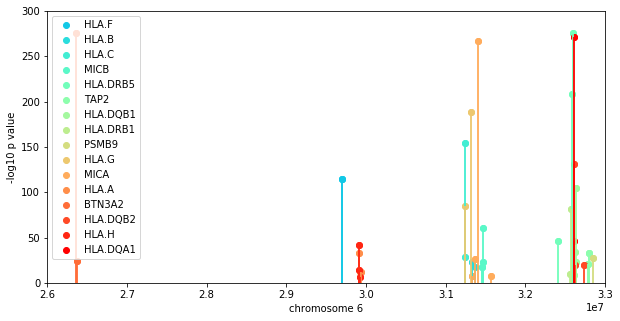

In [79]:
f=plt.figure(figsize=(10,5))
for t in hla_merge.file.unique():
    plt.scatter(hla_merge[hla_merge.file==t]["bp1"], hla_merge[hla_merge.file==t]["-log10p"],label=t,color=color_dict[t])
    plt.vlines(x=hla_merge[hla_merge.file==t]["bp1"], ymin=0,ymax=hla_merge[hla_merge.file==t]["-log10p"], color=color_dict[t], alpha=0.7, linewidth=2)
plt.legend()
plt.ylim([0, 300])
plt.xlim([26000000, 33000000])
plt.ylabel("-log10 p value")
plt.xlabel("chromosome 6")
plt.savefig("../plots/hla.cond.pdf")

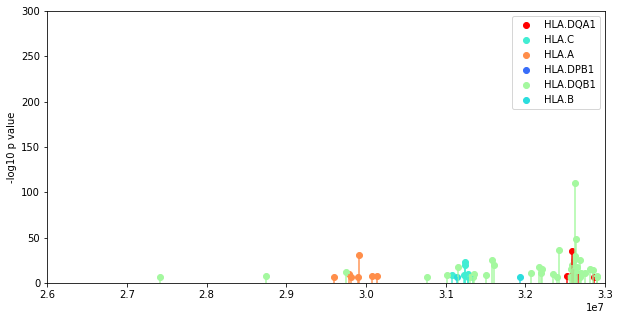

In [81]:
f=plt.figure(figsize=(10,5))
for t in ase6.file.unique():
    plt.scatter(ase6[ase6.file==t]["bp1"], ase6[ase6.file==t]["-log10"],label=t,color=color_dict[t])
    plt.vlines(x=ase6[ase6.file==t]["bp1"], ymin=0,ymax=ase6[ase6.file==t]["-log10"], color=color_dict[t], alpha=0.7, linewidth=2)
plt.legend()
plt.ylim([0, 300])
plt.xlim([26000000, 33000000])
plt.ylabel("-log10 p value")
plt.savefig("../plots/hla.ase.pdf")

## Make dataframes

In [82]:
ase6_filt=ase6[["snps","file","beta","p-value"]]
ase6_filt.columns=["snp","file","beta","p-value"]
ase6_filt["method"]="ase"

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [83]:
cond_filt=hla_merge[["snp","file","beta mean","consensus p-value"]]
cond_filt.columns=["snp","file","beta","p-value"]
cond_filt["method"]="conditional"

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [84]:
total_hla=ase6_filt.append(cond_filt)

In [85]:
total_hla=total_hla.drop_duplicates()

In [87]:
#map to rsid
total_hla['variant'] = total_hla['snp'].apply(lambda x: map_rsid(x)[0])
total_hla['rsid'] = total_hla['snp'].apply(lambda x: map_rsid(x)[1])

querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1.

In [93]:
total_hla.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/immune-microenvironment-hla.tsv",index=None,sep="\t")

## Extract file

In [94]:
snps=total_hla["snp"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in total_hla["snp"].tolist()]

In [95]:
extract=pd.DataFrame({"snps":snps})

In [96]:
extract.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/extract-hla-variants.txt",header=None,sep="\t",index=None)

## Export for LDtrait

In [102]:
for num,data in enumerate(np.array_split(total_hla["rsid"], 10)):
    print(len(data))
    data.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/LDtrait/hla.LDlink_input_"+str(num)+".tsv",header=None,index=None,sep="\t")

11
11
11
11
11
11
11
11
11
10


## Get LDtrait output

In [7]:
directory="/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/LDtrait/"

In [8]:
files=[x for x in os.listdir(directory) if "hla_LDlink_output_" in x]

In [9]:
total_gwas=pd.DataFrame()

for x in files:
    gwas=pd.read_csv(directory+x,delimiter="\t")
    total_gwas=total_gwas.append(gwas)

In [10]:
mp_trait={}

for x in total_gwas["Query"].unique():
    mp_trait[x]=total_gwas[total_gwas["Query"]==x]["GWAS Trait"].unique().tolist()
    
    

In [11]:
total_gwas["GWAS Trait"].value_counts()

Blood protein levels                           58
Asthma                                         43
Multiple sclerosis                             27
Schizophrenia                                  23
Lung cancer                                    21
                                               ..
Smoking status (ever vs never smokers)          1
Lung function (low FEV1 vs high FEV1)           1
Pre-treatment viral load in HIV-1 infection     1
Rheumatoid arthritis (ACPA-negative)            1
Feeling worry                                   1
Name: GWAS Trait, Length: 313, dtype: int64

## Plot GWAS traits

In [13]:
g=[]
c=[]

for x in total_gwas["GWAS Trait"].unique():
    g.append(x)
    c.append(len(total_gwas[total_gwas["GWAS Trait"]==x]["Query"].unique()))

In [14]:
gwas_counts=pd.DataFrame({"gwas":g,"counts":c})
gwas_counts=gwas_counts.sort_values(by="counts",ascending=False)

In [15]:
gwas_counts["counts"]=gwas_counts["counts"]

In [16]:
gwas_counts_filt=gwas_counts[gwas_counts["counts"]>5]

In [20]:
gwas_counts_filt["gwas"]=gwas_counts_filt["gwas"].str.split("(").str[0]
mp={"Asthma ":"Asthma"}

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
gwas_counts_filt["gwas"]=gwas_counts_filt["gwas"].map(mp).fillna(gwas_counts_filt["gwas"])

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


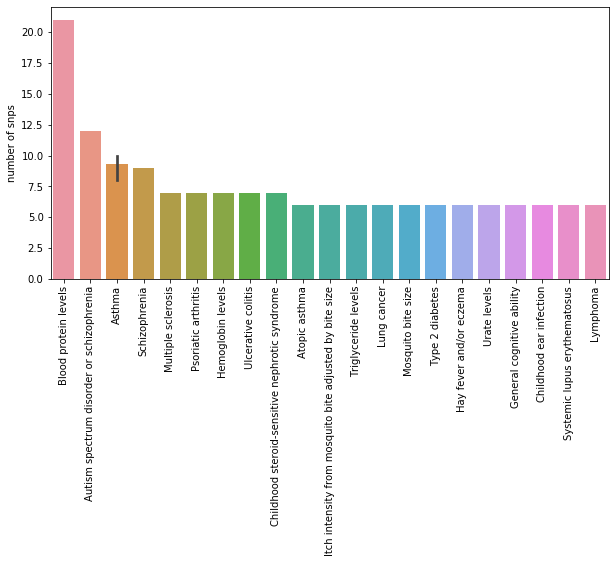

In [22]:
f=plt.figure(figsize=(10,5))
ax = sns.barplot(x="gwas", y="counts", data=gwas_counts_filt)
plt.xlabel("")
plt.ylabel("number of snps")
plt.xticks(rotation=90)
f.savefig("../plots/gwas.pdf")

In [23]:
df=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/immune-microenvironment-hla.tsv",delimiter="\t")

In [26]:
df[df["rsid"]=="rs2844806"]

,snp,file,beta,p-value,method,variant,rsid
96,6:29933439:T:C,HLA.A,0.116323,9.748700e-13,conditional,chr6:g.29933439C>T,rs2844806
